<img src="https://mma.prnewswire.com/media/76307/lending_club_logo.jpg?p=facebook" alt="Alt text" width="700"/>

# Table of Contents


1. [Introduction](#Introduction)
2. [Data Dictionary](#Data-Dictionary)
3. [Data Cleaning and Preprocessing](#Data-Cleaning-and-Preprocessing)
4. [Feature Engineering](#Feature-Engineering)
5. [Exploratory Data Analysis and Visualisation](#Exploratory-Data-Analysis-and-Visualisation)
6. [Models](#Models)
    - [Logistic Regression](#Logistic-Regression)
    - [Random Forest Classifier](#Random-Forest-Classifier)
    - [XGBoost](#XGBoost)
    - [Neural Network](#Neural-Network)
7. [Results](#Results)
8. [Future Work](#Future-Work)



## Introduction

### Dataset
The dataset used for this project is derived from [Lending Club](https://www.lendingclub.com/), a peer-to-peer lending platform. It contains historical loan data, including borrower characteristics, loan information, and performance metrics. The dataset encompasses various features such as annual income, loan amounts, credit scores, and repayment history, enabling a comprehensive analysis of factors influencing loan defaults.

### Purpose of the Project
The primary objective of this project is to develop a predictive model to identify borrowers at risk of defaulting on their loans. By analyzing historical data and engineering relevant features, the project aims to leverage machine learning techniques to enhance decision-making processes for lenders.

The project focuses on:

- **Feature Engineering:** Creating meaningful features that capture borrower risk profiles and payment behaviors.
- **Model Development:** Training and evaluating various machine learning models, including XGBoost, logistic regression, and neural networks, to achieve accurate predictions of loan defaults.
- **Interpretability:** Providing insights into the importance of different features in predicting defaults to aid lenders in understanding risk factors.
- **Deployment:** Developing a framework for deploying the predictive model as an API for real-time loan default predictions.

This project ultimately seeks to contribute to more informed lending practices and reduce the financial risks associated with loan defaults.


## Data Dictionary

This data dictionary provides definitions and descriptions of the key features used in the loan default prediction model.

| Feature Name                   | Type         | Description                                                                                       |
|--------------------------------|--------------|---------------------------------------------------------------------------------------------------|
| `annual_inc`                   | Numeric      | The annual income of the borrower.                                                                |
| `loan_amnt`                    | Numeric      | The total amount of the loan requested by the borrower.                                          |
| `dti`                          | Numeric      | Debt-to-Income ratio, calculated as total monthly debt payments divided by monthly income.       |
| `fico_range_low`               | Numeric      | The lower bound of the FICO credit score range for the borrower.                                 |
| `delinq_2yrs`                 | Numeric      | Number of delinquencies in the last 2 years.                                                    |
| `inq_last_6mths`              | Numeric      | Number of inquiries made into the borrower’s credit report in the last 6 months.                 |
| `term`                         | Categorical  | The duration of the loan, typically expressed in months (e.g., "36 months" or "60 months").     |
| `purpose`                      | Categorical  | The purpose of the loan, such as "credit_card", "debt_consolidation", or "home_improvement".    |
| `home_ownership`               | Categorical  | The borrower's home ownership status, which can be "MORTGAGE", "OWN", or "RENT".                 |
| `high_dti_risk`               | Binary       | Indicates whether the DTI ratio is high risk (1 if DTI > 35%, else 0).                          |
| `income_category`              | Categorical  | Categorizes annual income into "Low", "Medium", or "High" based on thresholds.                  |
| `fico_risk_group`             | Categorical  | Categorizes the FICO score into groups: "Poor", "Fair", "Good", or "Excellent".                  |
| `recent_inquiry_flag`         | Binary       | Indicates whether the borrower has made more than 2 credit inquiries in the last 6 months (1 or 0). |
| `loan_to_income_ratio`        | Numeric      | The ratio of the loan amount to the borrower's annual income.                                    |
| `interest_to_income_ratio`     | Numeric      | The ratio of the monthly loan installment to the borrower's annual income.                        |
| `loan_term_risk`              | Categorical  | Categorizes loan duration into "Short term" or "Long term" based on the loan term.              |
| `delinquency_risk`            | Binary       | Indicates if there have been any delinquencies in the past 2 years (1 if yes, else 0).          |
| `public_record_flag`          | Binary       | Indicates whether the borrower has any public records, such as bankruptcy (1 if yes, else 0).   |
| `home_ownership_risk`         | Binary       | Differentiates between "MORTGAGE" or "OWN" and "RENT" (1 if mortgage/own, else 0).             |
| `purpose_group`               | Categorical  | Groups loan purposes into "Personal", "Business", or "Other" based on the specified categories.  |


# Import Packages

In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

import seaborn as sns
import matplotlib.pyplot as plt
import hvplot.pandas
palette = sns.color_palette("Set2")

from scipy import stats
from scipy.stats import normaltest, shapiro, anderson, kstest, skew
from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import (train_test_split, cross_val_score, GridSearchCV, 
                                     RepeatedStratifiedKFold)
from sklearn.metrics import (classification_report, accuracy_score, precision_score, 
                             recall_score, f1_score, roc_auc_score, confusion_matrix, 
                             mean_absolute_error, mean_squared_error, r2_score, roc_curve, auc)
from sklearn.utils.class_weight import compute_class_weight

from xgboost import XGBClassifier
import xgboost as xgb

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LeakyReLU
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import AUC
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2


# Load Data and Dictionary 

In [2]:
lending_data = pd.read_csv('C:/Users/dicki/Desktop/DS in Finance/data/1-raw/lending-club-2007-2020Q3/Loan_status_2007-2020Q3-100ksample.csv')
dictionary = pd.read_excel('C:/Users/dicki/Desktop/DS in Finance/data/dictionary.xlsx', sheet_name='LoanStats')

lending_data.drop(columns=['Unnamed: 0.1','Unnamed: 0','url', 'title', 'emp_title'], inplace=True)
print(lending_data.shape)
display(lending_data.head(2))


notes = pd.DataFrame([dictionary['Description'].values], columns=dictionary['LoanStatNew'])
print(notes.shape)
display(notes.head())


(100000, 138)


,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,purpose,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,debt_settlement_flag
0,167338079,4000.0,4000.0,4000.0,36 months,13.08%,134.93,B,B5,10+ years,MORTGAGE,48000.0,Source Verified,Mar-2020,Current,n,home_improvement,115xx,NY,20.25,1.0,Dec-2004,665.0,669.0,0.0,19.0,110.0,4.0,1.0,1988.0,82.8%,12.0,w,3816.34,3816.34,266.95,266.95,183.66,83.29,0.0,0.0,0.0,May-2020,134.93,Jun-2020,May-2020,669.0,665.0,1.0,NaN,1.0,Individual,NaN,NaN,NaN,0.0,3832.0,259024.0,0.0,1.0,0.0,1.0,16.0,9960.0,56.0,0.0,0.0,0.0,59.0,2400.0,1.0,0.0,0.0,1.0,64756.0,NaN,NaN,0.0,0.0,179.0,75.0,38.0,16.0,2.0,NaN,19.0,16.0,19.0,1.0,0.0,2.0,0.0,1.0,5.0,2.0,5.0,2.0,4.0,0.0,0.0,0.0,0.0,75.0,NaN,1.0,0.0,395328.0,11948.0,0.0,17928.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N
1,71016917,24000.0,24000.0,24000.0,60 months,9.16%,500.07,B,B2,6 years,RENT,57000.0,Source Verified,Feb-2016,Current,n,credit_card,708xx,LA,25.33,0.0,Jan-2004,680.0,684.0,0.0,NaN,NaN,10.0,0.0,22697.0,64.5%,24.0,w,4333.29,4333.29,25496.16,25496.16,19666.71,5829.45,0.0,0.0,0.0,May-2020,500.07,Jun-2020,May-2020,704.0,700.0,0.0,NaN,1.0,Individual,NaN,NaN,NaN,0.0,0.0,61815.0,0.0,3.0,0.0,3.0,14.0,39118.0,72.0,1.0,1.0,2137.0,67.0,35200.0,0.0,7.0,0.0,4.0,6182.0,7741.0,40.5,0.0,0.0,145.0,137.0,7.0,7.0,0.0,7.0,NaN,24.0,NaN,0.0,3.0,5.0,5.0,6.0,15.0,7.0,9.0,5.0,10.0,0.0,0.0,0.0,1.0,95.8,60.0,0.0,0.0,88154.0,61815.0,13000.0,52954.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N


(1, 153)


LoanStatNew,acc_now_delinq,acc_open_past_24mths,addr_state,all_util,annual_inc,annual_inc_joint,application_type,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,collection_recovery_fee,collections_12_mths_ex_med,delinq_2yrs,delinq_amnt,desc,dti,dti_joint,earliest_cr_line,emp_length,emp_title,fico_range_high,fico_range_low,funded_amnt,funded_amnt_inv,grade,home_ownership,id,il_util,initial_list_status,inq_fi,inq_last_12m,inq_last_6mths,installment,int_rate,issue_d,last_credit_pull_d,last_fico_range_high,last_fico_range_low,last_pymnt_amnt,last_pymnt_d,loan_amnt,loan_status,max_bal_bc,member_id,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_last_delinq,mths_since_last_major_derog,mths_since_last_record,mths_since_rcnt_il,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,next_pymnt_d,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,open_acc,open_acc_6m,open_il_12m,open_il_24m,open_act_il,open_rv_12m,open_rv_24m,out_prncp,out_prncp_inv,pct_tl_nvr_dlq,percent_bc_gt_75,policy_code,pub_rec,pub_rec_bankruptcies,purpose,pymnt_plan,recoveries,revol_bal,revol_util,sub_grade,tax_liens,term,title,tot_coll_amt,tot_cur_bal,tot_hi_cred_lim,total_acc,total_bal_ex_mort,total_bal_il,total_bc_limit,total_cu_tl,total_il_high_credit_limit,total_pymnt,total_pymnt_inv,total_rec_int,total_rec_late_fee,total_rec_prncp,total_rev_hi_lim,url,verification_status,verified_status_joint,zip_code,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term,NaN,NaN
0,The number of accounts on which the borrower is now delinquent.,Number of trades opened in past 24 months.,The state provided by the borrower in the loan application,Balance to credit limit on all trades,The self-reported annual income provided by the borrower during registration.,The combined self-reported annual income provided by the co-borrowers during registration,Indicates whether the loan is an individual application or a joint application with two co-borrowers,Average current balance of all accounts,Total open to buy on revolving bankcards.,Ratio of total current balance to high credit/credit limit for all bankcard accounts.,Number of charge-offs within 12 months,post charge off collection fee,Number of collections in 12 months excluding medical collections,The number of 30+ days past-due incidences of delinquency in the borrower's credit file for the past 2 years,The past-due amount owed for the accounts on which the borrower is now delinquent.,Loan description provided by the borrower,"A ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested LC loan, divided by the borrower’s self-reported monthly income.","A ratio calculated using the co-borrowers' total monthly payments on the total debt obligations, excluding mortgages and the requested LC loan, divided by the co-borrowers' combined self-reported monthly income",The month the borrower's earliest reported credit line was opened,Employment length in years. Possible values are between 0 and 10 whe

In [3]:
notes['total_rec_prncp']

0    Principal received to date
Name: total_rec_prncp, dtype: object

## Data Cleaning and Preprocessing

**Drop Unwanted Loan Statuses**: Remove rows where the `loan_status` falls into irrelevant categories such as `'Current'`, `'Late (31-120 days)'`, `'In Grace Period'`, `'Late (16-30 days)'`, and `'Issued'`, as they are not useful for our analysis.

Define a mapping dictionary to consolidate loan statuses:
- `'Fully Paid'` and `'Does not meet the credit policy. Status:Fully Paid'` are mapped to `'Fully Paid'`.
- `'Charged Off'`, `'Default'`, and `'Does not meet the credit policy. Status:Charged Off'` are mapped to `'Charged Off'`.

- `'Fully Paid'` is assigned `0`.
- `'Charged Off'` is assigned `1`.

In [4]:
df = lending_data.copy()

#Drop unwatned values
statuses_to_drop = ['Current',  'Late (31-120 days)', 'In Grace Period', 'Late (16-30 days)', 'Issued']
df = df.drop(df[df['loan_status'].isin(statuses_to_drop)].index)

status_mapping = {'Fully Paid': 'Fully Paid',
                  'Does not meet the credit policy. Status:Fully Paid': 'Fully Paid',
                  
                  'Charged Off': 'Charged Off',
                  'Does not meet the credit policy. Status:Charged Off': 'Charged Off',
                  'Default': 'Charged Off'}

#Map dictionary 
df['loan_status'] = df['loan_status'].replace(status_mapping)
#Convert to binary 
df['loan_status'] = df['loan_status'].replace({'Fully Paid': 0, 'Charged Off': 1})
df['loan_status'].value_counts()

loan_status
0    51258
1    12431
Name: count, dtype: int64

### Duplicates
 **There are none**

In [5]:
duplicates = df[df.duplicated()]
print(f"Number of duplicate rows: {duplicates.shape[0]}")

Number of duplicate rows: 0


### Remove Features (post loan information)

In [6]:
drop = ['pymnt_plan', 'total_pymnt', 'total_pymnt_inv','last_pymnt_d', 'last_pymnt_amnt', 'out_prncp',
           'out_prncp_inv', 'total_rec_prncp', 'hardship_flag', 'collection_recovery_fee',
           'collections_12_mths_ex_med', 'debt_settlement_flag','policy_code']

df.drop(columns=drop, axis=1, inplace=True)

### Handling Missing Values in the Dataset

**Calculate Percentage of Missing Values**:
   - Create a list of the percentage of missing values for each column in the DataFrame.
   - This helps identify columns that may not provide enough information for analysis.

The aim of these steps is to drop columns that won’t add high value with respect to insights. Due to high missingness, these dropped columns will not contribute high information to the dataset.


In [7]:
#Creat the percent of nans list
percent_nans = round(df.isna().mean() * 100, 2).sort_values()
high_nans_cols = [col for col in df.columns if percent_nans[col] > 70]

# print(high_nans_cols)
print(df.shape)

#Drop the nans with over 70% - being brutal to start with 
df.drop(columns=high_nans_cols, inplace=True)
print(df.shape)
# display(df.head(2))

(63689, 125)
(63689, 92)


#### Imputed (DTI)

In [8]:
#Find the missing values 
miss_vals = df.select_dtypes(include='number').isna().sum()
to_impute_cols = list(miss_vals[(miss_vals > 0) & ( miss_vals < 10000)].index) #Remove the ones which have mostly missing
#Find the numerical columsn and corr
num_cols_df = df.select_dtypes(include='number')
corr_matrix = num_cols_df.corr()
#Important features for loan_status
loan_imp_feats = corr_matrix['loan_status'].abs().nlargest(20) #Any value over 0.1
loan_imp_feats.head(10)

loan_status             1.000000
last_fico_range_high    0.650591
last_fico_range_low     0.563755
recoveries              0.532301
total_rec_late_fee      0.128820
fico_range_low          0.120072
fico_range_high         0.120069
acc_open_past_24mths    0.097097
open_rv_24m             0.093717
num_tl_op_past_12m      0.083299
Name: loan_status, dtype: float64

In [9]:

def imputer(df, col, num_features=10):
    num_cols_df = df.select_dtypes(include='number')
    corr_matrix = num_cols_df.corr()
    
    #col values
    important_features = corr_matrix[col].abs().nlargest(num_features + 1).index.tolist()
    important_features.remove(col)

    #Split nulls/not-nulls
    df_not_null = df[df[col].notnull()]
    df_null = df[df[col].isna()]

    #Predictive features/target
    X_train = df_not_null[important_features].dropna()
    y_train = df_not_null.loc[X_train.index, col]

    #Model/Scale   
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    model = LinearRegression()
    model.fit(X_train_scaled, y_train)

    #Predict missing values
    X_null = df_null[important_features].fillna(X_train.mean()) 
    X_null_scaled = scaler.transform(X_null)
    predicted_values = model.predict(X_null_scaled)
    #Fill missing values
    df.loc[df[col].isna(), col] = predicted_values
    print('Nulls:', df[col].isna().sum())
    return df


In [10]:
# Example usage
df = imputer(df, col='dti')

Nulls: 0


### Clean the Dates

In [11]:
#Looking for date cleaning 
dates = []
def date_finder(data):
    for col in data.columns:
        try:
            if 'date' in col.lower() or col.lower()[-2:] == '_d':  # :( ended up dropping the date columns anyway
                dates.append(col)
        except:
            pass #Some nan values in there
    
# date_finder(notes)
date_finder(df)
for date in dates:
    df[date] = pd.to_datetime(df[date], format='mixed')

#Create year/month for issue
df['issue_year'] = df['issue_d'].dt.year
df['issue_month'] = df['issue_d'].dt.month


### Clean the Zip coe

In [12]:

#convert zip from string to int
df['zip_code'] = df['zip_code'].apply(lambda x: str(x)[:3])
df['zip_code'] = pd.to_numeric(df['zip_code'], errors='coerce')
df['zip_code'].fillna(0, inplace=True)


### Map non-numerical values to Numerical 

In [13]:

#Make useful ones numerical 
length_map = {'10+ years': 10, '9 years': 9, '8 years': 8, '7 years': 7, '6 years': 6, '5 years': 5,
                      '4 years': 4, '3 years': 3, '2 years': 2, '1 year': 1, '< 1 year': 0.5, 'n/a': 0}

df['emp_length_int'] = df['emp_length'].map(length_map)

#Term numeric 
df['term_numeric'] = df['term'].str.replace(' months', '').astype(int)

# Remove pesky %
df['revol_util_int'] = df['revol_util'].str.replace('%', '').astype(float)
df['int_rate_int'] = df['int_rate'].str.replace('%', '').astype(float)

#Clena numerical nulls 
df[['tot_coll_amt', 'total_rev_hi_lim', 'tot_cur_bal']] = df[['tot_coll_amt', 'total_rev_hi_lim', 'tot_cur_bal']].fillna(0)

#Use Medians for skew values
df[['emp_length_int', 'pub_rec', 'total_acc']] = df[['emp_length_int', 'pub_rec', 
                                                     'total_acc']].apply(lambda col: col.fillna(col.median()))


#### Impute missing values in revol_util_int

In [14]:
df = imputer(df, col='revol_util_int')

Nulls: 0


### Outlier Detection 

The `count_outs` function counts outliers using the Interquartile Range (IQR) method. The `outliers` function filters the DataFrame to exclude these outliers and can create a new clean dataframe `if you want`.


In [15]:

#Count/Remove outliers 
def outliers(df, column, remove_outliers=False):
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    if remove_outliers:
        return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    else:
        return ((df[column] < lower_bound) | (df[column] > upper_bound)).sum()


In [16]:
outliers(df, 'annual_inc')

3026

,column,outlier_%
55,num_accts_ever_120_pd,22.24
6,loan_status,19.52
9,delinq_2yrs,18.80
15,pub_rec,16.61
24,tot_coll_amt,14.74
20,recoveries,14.18
71,pub_rec_bankruptcies,12.51
52,mths_since_recent_bc,8.58
43,bc_open_to_buy,8.16
49,mo_sin_rcnt_rev_tl_op,7.80


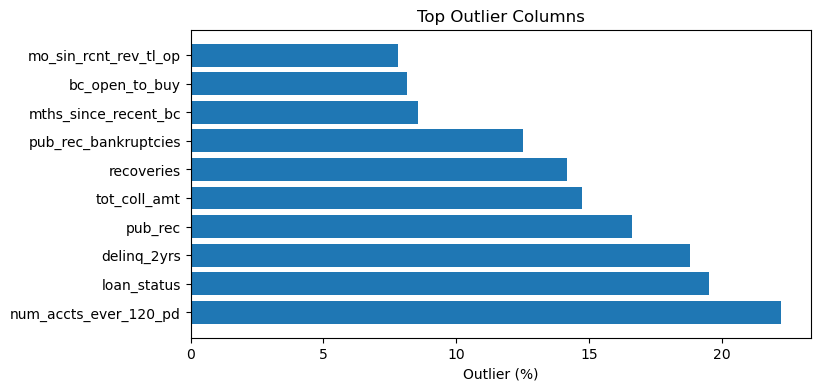

In [17]:
#Let's have a look at the outliers

outlier_df = pd.DataFrame({
    'column': df.select_dtypes(include='number').columns,
    'outlier_%': [
        round(outliers(df, col) / len(df) * 100, 2)
        for col in df.select_dtypes(include='number').columns]})


display(outlier_df.sort_values('outlier_%', ascending=False).head(10))

#plot the top outlier cols
top_outliers = outlier_df.sort_values('outlier_%', ascending=False).head(10)
plt.figure(figsize=(8, 4))
plt.barh(top_outliers['column'], top_outliers['outlier_%'])
plt.xlabel('Outlier (%)')
plt.title('Top Outlier Columns')
plt.show()



## Feature Engineering

This code snippet performs several feature engineering tasks on a DataFrame called `df`. It categorizes income into three groups (Low, Medium, High) based on annual income, assesses DTI risk by flagging high DTI values, and evaluates FICO scores by grouping them into categories (Poor, Fair, Good, Excellent). Additionally, it computes various ratios like loan-to-income and interest-to-income, flags recent inquiries, assesses payment history and public records for bankruptcy, differentiates home ownership risk, and categorizes loan purposes for default risk assessment.


In [18]:
#Cat the income 
df['income_category'] = df['annual_inc'].apply(lambda x: 'Low' if x < 50000 else ('Medium' if x < 100000 else 'High'))

#DTI risk (little googling to see the thresh)?
df['high_dti_risk'] = df['dti'].apply(lambda x: 1 if x > 35 else 0)

#FICO Eyeballed
df['fico_risk_group'] = df['fico_range_low'].apply(lambda x: 'Poor' if x < 580 else 
                                                             ('Fair' if x < 670 else 
                                                             ('Good' if x < 740 else 'Excellent')))

#Recent inquiry 
df['recent_inquiry_flag'] = df['inq_last_6mths'].apply(lambda x: 1 if x > 2 else 0)

#Loan-to-income ratio
df['loan_to_income_ratio'] = df['loan_amnt'] / df['annual_inc']

#Interest-to-Income ratio
df['interest_to_income_ratio'] = df['installment'] / df['annual_inc']

#Short Vs long term risks 
df['loan_term_risk'] = df['term'].apply(lambda x: 'Long term' if '60 months' in x else 'Short term')

#Payment History Category 
df['delinquency_risk'] = df['delinq_2yrs'].apply(lambda x: 1 if x > 0 else 0)

#Public record flag -Bankruptyc
df['public_record_flag'] = df['pub_rec'].apply(lambda x: 1 if x > 0 else 0)

#Home Ownership Risk: Differentiating between "MORTGAGE" and "OWN" versus "RENT"
df['home_ownership_risk'] = df['home_ownership'].apply(lambda x: 1 if x in ['MORTGAGE', 'OWN'] else 0)

#Purpose-based Default Risk Grouping
df['purpose_group'] = df['purpose'].apply(lambda x: 'Personal' if x in ['credit_card', 'home_improvement', 'major_purchase'] else 
                                                    ('Business' if x in ['small_business'] else 'Other'))
#Remove them inf values 
# df.replace([np.inf, -np.inf], np.nan, inplace=True)


In [19]:
#To infinity and ...
def check_infinity(df):
    infinite_list = df.isin([-np.inf, np.inf]).sum()

    if infinite_list.sum() == 0:
        print("No column has infinite values")
    else:
        print("Columns with infinite values:")
        print(infinite_list[infinite_list>0])

print(check_infinity(df))
df.replace([np.inf, -np.inf], 999, inplace=True)

Columns with infinite values:
loan_to_income_ratio        33
interest_to_income_ratio    33
dtype: int64
None


## Exploratory Data Analysis and Visualisation

In this section, I performed an exploratory data analysis (EDA) to gain insights into the Lending Club dataset. I began by examining the distributions of key numerical features such as `annual_inc`, `loan_amnt`, and `dti` to understand their characteristics and identify any potential anomalies. 

Next, I visualized the relationships between various features and the target variable, `loan_default`, using various plots, including histograms, box plots, and scatter plots. These visualizations helped highlight trends and patterns in the data, such as how different income categories and DTI ratios correlate with loan defaults.

Additionally, I utilized correlation heatmaps to explore the relationships between numerical features, allowing me to identify important predictors for the modeling phase. Overall, the EDA provided valuable insights that informed my feature engineering process and model selection.


#### Quick look at the Millionaires

Number of Millionaires: 24


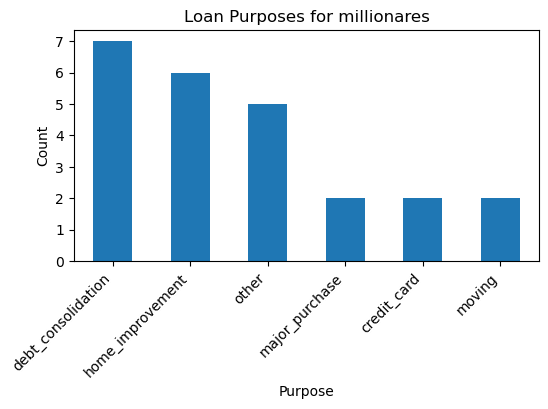

In [20]:

billion_df = df[df['annual_inc'] >= 1000000].sort_values(by='annual_inc', ascending = False)
# display(billion_df.head(2))
print('Number of Millionaires:', billion_df.shape[0])

# for i in range(24):
#     print(f'Billionaire number {i+1} got a loan for:')
#     print('Amount of:', billion_df['loan_amnt'].iloc[i])
#     print('Purpose:', billion_df['purpose'].iloc[i])
#     print('Interest rate of:', billion_df['int_rate'].iloc[i])
    
plt.figure(figsize=(6, 3))
billion_df['purpose'].value_counts().plot(kind='bar')
plt.xlabel('Purpose')
plt.ylabel('Count')
plt.title('Loan Purposes for millionares')
plt.xticks(rotation=45, ha='right')
plt.show()


### Loan Status 

In [21]:
df.groupby(by='loan_status')['loan_amnt'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
0,51258.0,14262.427816,8921.800461,700.0,7400.0,12000.0,20000.0,40000.0
1,12431.0,15768.719331,9058.922072,1000.0,9000.0,14400.0,21000.0,40000.0


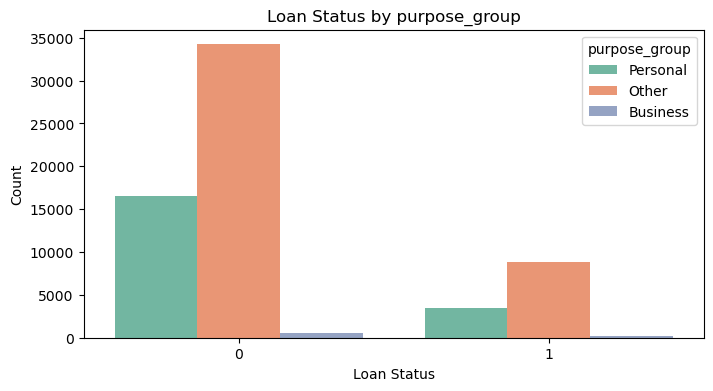

In [22]:

#Look at the spread of default against reasons for loan 
plt.figure(figsize=(8, 4))
sns.countplot(data=df, x='loan_status', hue='purpose_group', palette=palette)
plt.title('Loan Status by purpose_group')
plt.xlabel('Loan Status')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()


### Loan Amount Overviiew

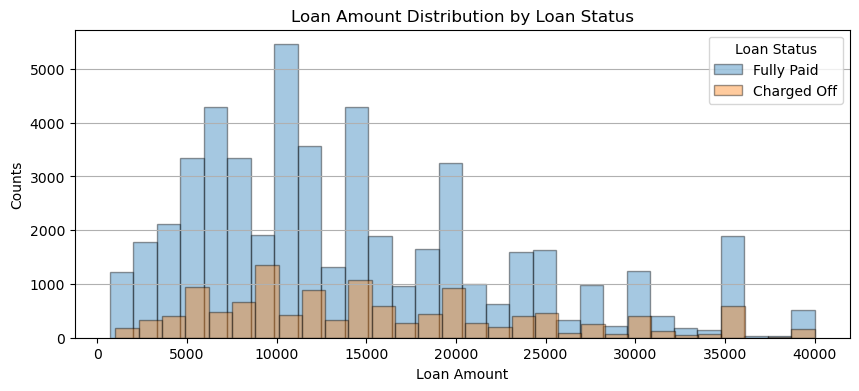

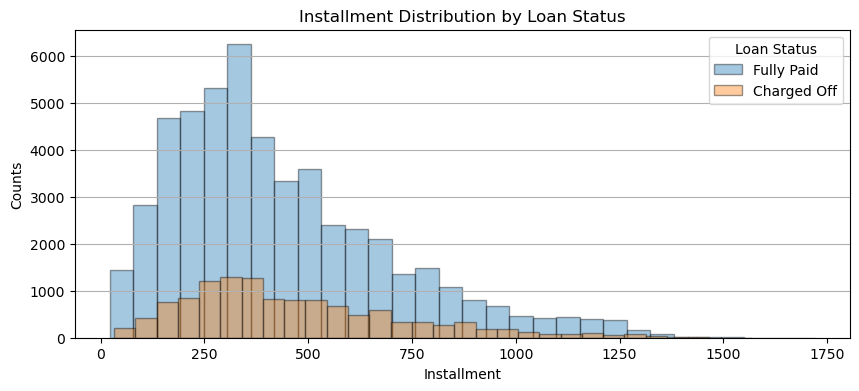

In [23]:

#Hist for loan_amnt
plt.figure(figsize=(10, 4))
for status in df['loan_status'].unique():
    plt.hist(df[df['loan_status'] == status]['loan_amnt'], bins=30, alpha=0.4, edgecolor='black')

plt.title('Loan Amount Distribution by Loan Status')
plt.xlabel('Loan Amount')
plt.ylabel('Counts')
plt.legend(['Fully Paid', 'Charged Off'], title='Loan Status')
plt.grid(axis='y')
plt.show()

#Hist for installmetns
plt.figure(figsize=(10, 4))
for status in df['loan_status'].unique():
    plt.hist(df[df['loan_status'] == status]['installment'], bins=30, alpha=0.4, edgecolor='black')
plt.title('Installment Distribution by Loan Status')
plt.xlabel('Installment')
plt.ylabel('Counts')
plt.legend(['Fully Paid', 'Charged Off'], title='Loan Status')
plt.grid(axis='y')
plt.show()


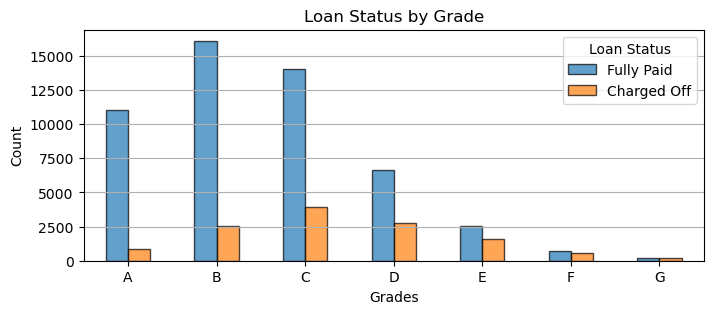

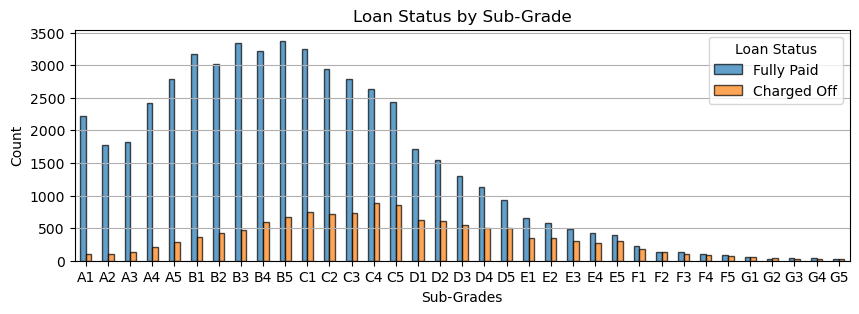

In [24]:

#Count the grades by loan status
fully_paid_grades = df.loc[df['loan_status'] == 0, 'grade'].value_counts()
charged_off_grades = df.loc[df['loan_status'] == 1, 'grade'].value_counts()
grades_df = pd.DataFrame({'Fully Paid': fully_paid_grades, 'Charged Off': charged_off_grades}).fillna(0)
# display(grades_df.head(2))

#Count the sub-grades by loan status
fully_paid_sub_grades = df.loc[df['loan_status'] == 0, 'sub_grade'].value_counts()
charged_off_sub_grades = df.loc[df['loan_status'] == 1, 'sub_grade'].value_counts()
sub_grades_df = pd.DataFrame({'Fully Paid': fully_paid_sub_grades, 'Charged Off': charged_off_sub_grades}).fillna(0)
# display(sub_grades_df.head(2))

#Grade plot
grades_df.plot(kind='bar', figsize=(8, 3), alpha=0.7, edgecolor='black')
plt.title('Loan Status by Grade')
plt.xlabel('Grades')
plt.ylabel('Count')
plt.legend(title='Loan Status', loc='upper right')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.show()

#Sub-Grade plot
sub_grades_df.plot(kind='bar', figsize=(10, 3), alpha=0.7, edgecolor='black')
plt.title('Loan Status by Sub-Grade')
plt.xlabel('Sub-Grades')
plt.ylabel('Count')
plt.legend(title='Loan Status', loc='upper right')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.show()


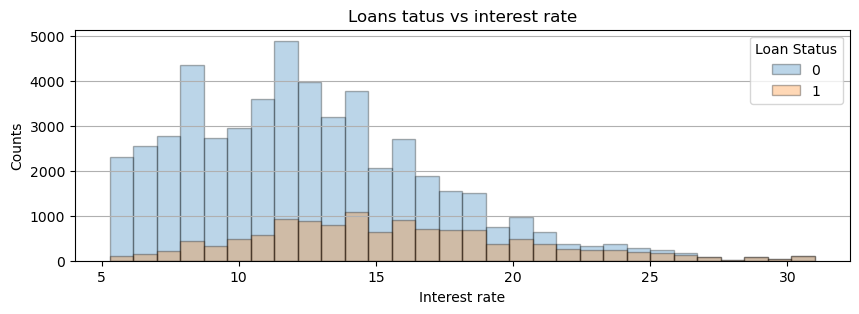

In [25]:

# Histogram for interest_rate
plt.figure(figsize=(10,3))
for status in df['loan_status'].unique():
    plt.hist(df[df['loan_status'] == status]['int_rate_int'], 
             bins=30, alpha=0.3, label=status, edgecolor='black')

plt.title('Loans tatus vs interest rate')
plt.xlabel('Interest rate')
plt.ylabel('Counts')
plt.legend(title='Loan Status', loc='upper right')
plt.grid(axis='y')
plt.show()


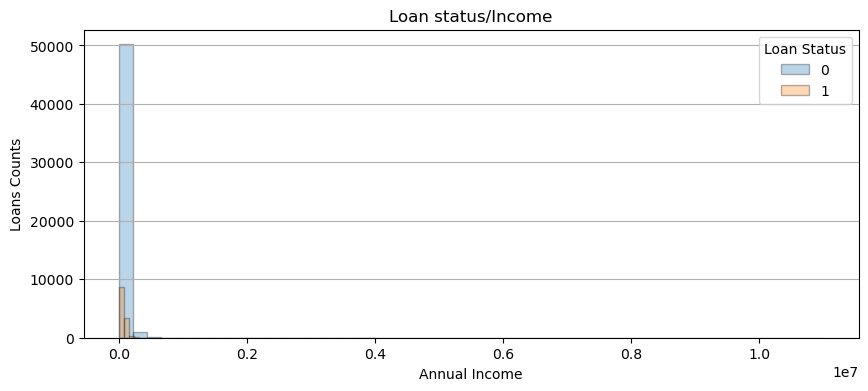

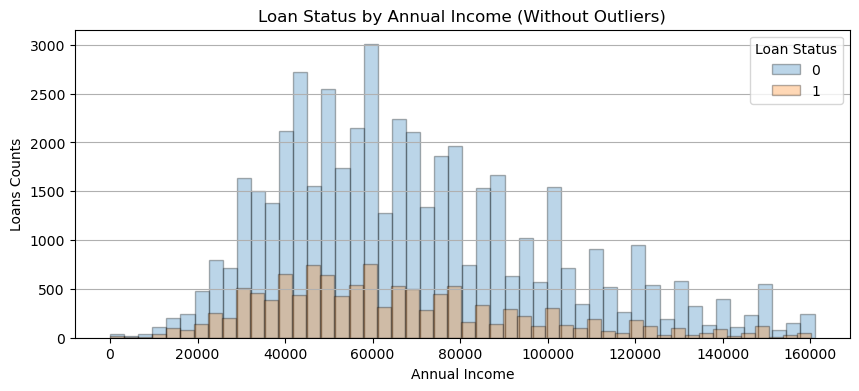

In [26]:

#Histogram for annual_inc
plt.figure(figsize=(10,4))
for status in df['loan_status'].unique():
    plt.hist(df[df['loan_status'] == status]['annual_inc'], 
             bins=50, alpha=0.3, label=status, edgecolor='black')
plt.title('Loan status/Income')
plt.xlabel('Annual Income')
plt.ylabel('Loans Counts')
plt.legend(title='Loan Status', loc='upper right')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.show()

# Histogram for annual_inc with outliers removed
df_no_outliers = outliers(df, 'annual_inc', remove_outliers=True)
plt.figure(figsize=(10, 4))
for status in df_no_outliers['loan_status'].unique():
    plt.hist(df_no_outliers[df_no_outliers['loan_status'] == status]['annual_inc'], bins=50, alpha=0.3, 
             label=status, edgecolor='black')
plt.title("Loan Status by Annual Income (Without Outliers)")
plt.xlabel('Annual Income')
plt.ylabel('Loans Counts')
plt.legend(title='Loan Status', loc='upper right')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.show()


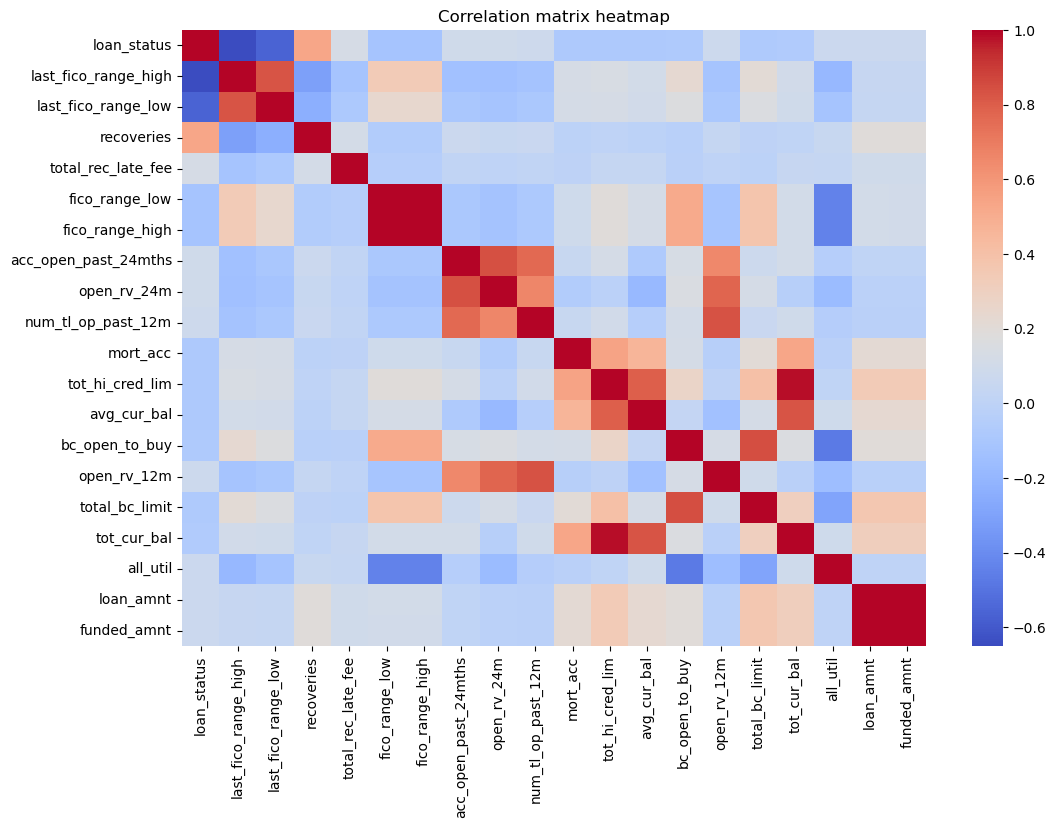

In [27]:

#Heatmap
corr_mat = df[list(loan_imp_feats.index)].corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_mat,fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Correlation matrix heatmap')
plt.show()


## Models

The dataset was split into training and testing sets to evaluate the performance of the predictive models. The initial split consisted of **70%** of the data used for training and **30%** for testing. 

In cases where the target variable, **`loan_default`**, exhibited class imbalance, the **Synthetic Minority Over-sampling Technique (SMOTE)** was employed to address this issue. SMOTE generates synthetic samples for the minority class, effectively balancing the class distribution. This step is crucial in scenarios like loan default prediction, where the number of defaults may be significantly lower than the number of non-defaults. By ensuring a balanced dataset, the models can learn more effectively from the available data.

The models presented in this section represent the **best results** obtained after rigorous experimentation with various algorithms and hyperparameters. I fine-tuned these models to achieve the highest possible accuracy and predictive performance. 


## SPLITS
### Normal split and SMOTE split

In [28]:
num_features = ['loan_amnt', 'int_rate_int', 'installment', 'term_numeric', 'annual_inc', 'zip_code',
        'emp_length_int', 'dti', 'fico_range_high', 'revol_util_int', 'loan_to_income_ratio',
        'interest_to_income_ratio', 'high_dti_risk', 'public_record_flag', 'home_ownership_risk']

cat_features = ['grade', 'sub_grade', 'income_category', 'fico_risk_group', 'loan_term_risk', 'purpose_group']

total_features = num_features + cat_features

#Not too many nulls
print('Check Nulls:',df[total_features].isna().sum().sum())

Check Nulls: 0


In [29]:
#dummify cat_features
df_dummified = pd.get_dummies(df[cat_features + num_features], columns=cat_features, drop_first=True)

#impute missing vals
imputer = SimpleImputer()
X = imputer.fit_transform(df_dummified)
y = df['loan_status']

#split noramlly 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#SMOTE sampling
smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(X, y)

#split smapled
X_train_sampled, X_test_sampled, y_train_sampled, y_test_sampled = train_test_split(X_resampled, y_resampled, 
                                                                                    test_size=0.2, random_state=42)

#Mini sample for grid searches
df_mini = df.sample(10000, random_state=42)
df_mini_dummified = pd.get_dummies(df_mini[cat_features + num_features], columns=cat_features, drop_first=True)
X_mini = imputer.fit_transform(df_mini_dummified)
y_mini = df_mini['loan_status']
X_train_mini, X_test_mini, y_train_mini, y_test_mini = train_test_split(X_mini, y_mini, test_size=0.2, random_state=42)

In [30]:
def plot_roc_curve(y_true, y_pred_prob, model_name):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'(ROC) Curve - {model_name}')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()

    print(f'ROC AUC Score: {roc_auc_score(y_true, y_pred_prob):.2f}')

## Logistic Regression

Accuracy= 0.8032658188098603
Precision= 0.46511627906976744
Recall= 0.03207698476343224
F1-Score= 0.06001500375093773
ROC-AUC= 0.6970606848079279
Confusion Matrix=
[[10152    92]
 [ 2414    80]]


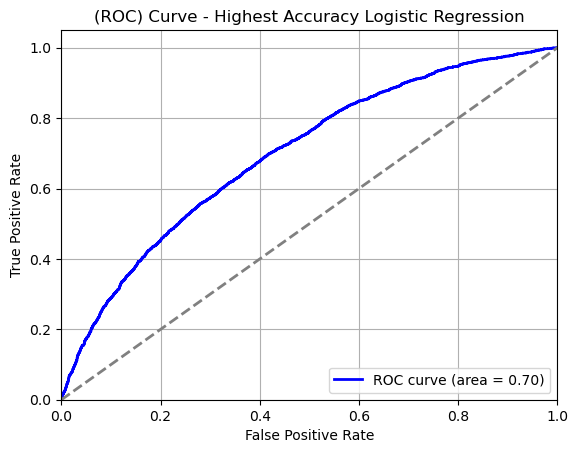

ROC AUC Score: 0.70


In [31]:
model_1 = LogisticRegression(C=0.1, penalty='l1', solver='liblinear', random_state=42)
model_1.fit(X_train, y_train)

predictions = model_1.predict(X_test)
y_pred_prob = model_1.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)
f1 = f1_score(y_test, predictions)
roc_auc = roc_auc_score(y_test, model_1.predict_proba(X_test)[:,1])
cm = confusion_matrix(y_test, predictions)

print(f'Accuracy= {accuracy}')
print(f'Precision= {precision}')
print(f'Recall= {recall}')
print(f'F1-Score= {f1}')
print(f'ROC-AUC= {roc_auc}')
print(f'Confusion Matrix=\n{cm}')

#add it to a dict
metrics_dict = {}
metrics_dict['m1_logistic_accuracy_hyp_accuracy'] = accuracy
metrics_dict['m1_logistic_accuracy_hyp_precision'] = precision
metrics_dict['m1_logistic_accuracy_hyp_recall'] = recall
metrics_dict['m1_logistic_accuracy_hyp_f1'] = f1
metrics_dict['m1_logistic_accuracy_hyp_roc_auc'] = roc_auc
metrics_dict['m1_logistic_accuracy_hyp_confusion_matrix'] = cm
    
plot_roc_curve(y_test, y_pred_prob, model_name='Highest Accuracy Logistic Regression')

## Random Forest Classifier 

Accuracy: 0.8747561451424113
Precision: 0.9679385590637571
Recall: 0.7750122010736945
F1-Score: 0.8607979184735473
ROC-AUC: 0.9255198604080142
Confusion Matrix:
[[9996  263]
 [2305 7940]]


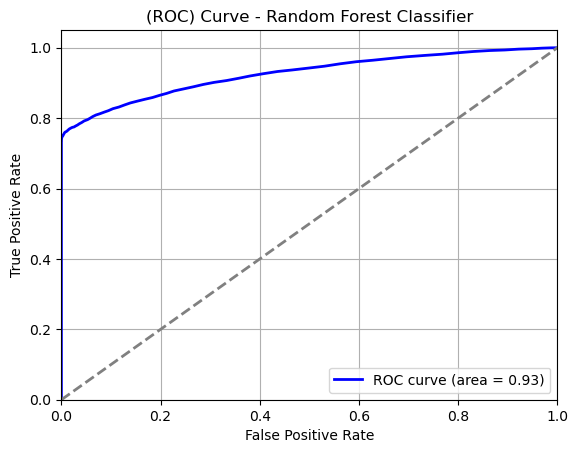

ROC AUC Score: 0.93


In [32]:

#Modelling time 
model_2rfs = RandomForestClassifier(n_estimators=100, random_state=42)  
model_2rfs.fit(X_train_sampled, y_train_sampled)
predictions = model_2rfs.predict(X_test_sampled)
y_pred_prob = model_2rfs.predict_proba(X_test_sampled)[:, 1]

accuracy = accuracy_score(y_test_sampled, predictions)
precision = precision_score(y_test_sampled, predictions)
recall = recall_score(y_test_sampled, predictions)
f1 = f1_score(y_test_sampled, predictions)
roc_auc = roc_auc_score(y_test_sampled, y_pred_prob)  # Use y_pred_prob here
cm = confusion_matrix(y_test_sampled, predictions)

#add it to a dict
metrics_dict['m2_ran_forest_smote_accuracy']= accuracy
metrics_dict['m2_ran_forest_smote_precision']= precision
metrics_dict['m2_ran_forest_smote_recall']= recall
metrics_dict['m2_ran_forest_smote_f1']= f1
metrics_dict['m2_ran_forest_smote_roc_auc']= roc_auc
metrics_dict['m2_ran_forest_smote_confusion_matrix']= cm
    
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1-Score: {f1}')
print(f'ROC-AUC: {roc_auc}')
print(f'Confusion Matrix:\n{cm}')

plot_roc_curve(y_test_sampled, y_pred_prob, model_name='Random Forest Classifier')

## XGBoost

Accuracy: 0.871439719079204
Precision: 0.9643598193579885
Recall: 0.7712054660810151
F1-Score: 0.8570343855081897
ROC-AUC: 0.9233989501106314
Confusion Matrix:
[[9967  292]
 [2344 7901]]


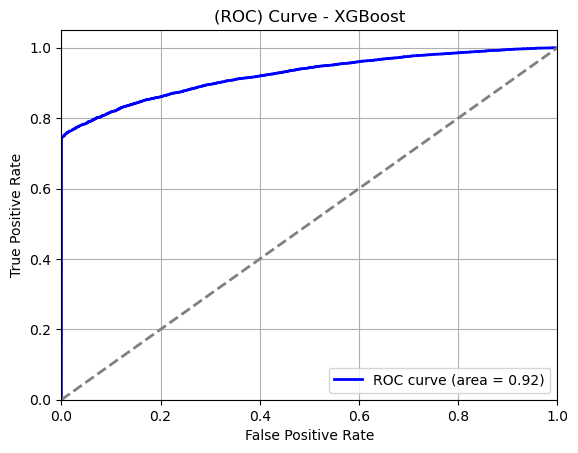

ROC AUC Score: 0.92


In [33]:
model_2xgb = xgb.XGBClassifier(random_state=42)
model_2xgb.fit(X_train_sampled, y_train_sampled)
predictions = model_2xgb.predict(X_test_sampled)
y_pred_prob = model_2xgb.predict_proba(X_test_sampled)[:, 1]

accuracy = accuracy_score(y_test_sampled, predictions)
precision = precision_score(y_test_sampled, predictions)
recall = recall_score(y_test_sampled, predictions)
f1 = f1_score(y_test_sampled, predictions)
roc_auc = roc_auc_score(y_test_sampled, model_2xgb.predict_proba(X_test_sampled)[:, 1])
cm = confusion_matrix(y_test_sampled, predictions)

metrics_dict['m2_xbg_class_accuracy']= accuracy
metrics_dict['m2_xbg_class_precision']= precision
metrics_dict['m2_xbg_class_recall']= recall
metrics_dict['m2_xbg_class_f1']= f1
metrics_dict['m2_xbg_class_roc_auc']= roc_auc
metrics_dict['m2_xbg_class_confusion_matrix']= cm
    
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1-Score: {f1}')
print(f'ROC-AUC: {roc_auc}')
print(f'Confusion Matrix:\n{cm}')

plot_roc_curve(y_test_sampled, y_pred_prob, model_name='XGBoost')

In [34]:
metrics_dict

{'m1_logistic_accuracy_hyp_accuracy': 0.8032658188098603,
 'm1_logistic_accuracy_hyp_precision': 0.46511627906976744,
 'm1_logistic_accuracy_hyp_recall': 0.03207698476343224,
 'm1_logistic_accuracy_hyp_f1': 0.06001500375093773,
 'm1_logistic_accuracy_hyp_roc_auc': 0.6970606848079279,
 'm1_logistic_accuracy_hyp_confusion_matrix': array([[10152,    92],
        [ 2414,    80]], dtype=int64),
 'm2_ran_forest_smote_accuracy': 0.8747561451424113,
 'm2_ran_forest_smote_precision': 0.9679385590637571,
 'm2_ran_forest_smote_recall': 0.7750122010736945,
 'm2_ran_forest_smote_f1': 0.8607979184735473,
 'm2_ran_forest_smote_roc_auc': 0.9255198604080142,
 'm2_ran_forest_smote_confusion_matrix': array([[9996,  263],
        [2305, 7940]], dtype=int64),
 'm2_xbg_class_accuracy': 0.871439719079204,
 'm2_xbg_class_precision': 0.9643598193579885,
 'm2_xbg_class_recall': 0.7712054660810151,
 'm2_xbg_class_f1': 0.8570343855081897,
 'm2_xbg_class_roc_auc': 0.9233989501106314,
 'm2_xbg_class_confusion_matri

## Best Model Summary
**XGBoost** has the highest accuracy (0.863), precision (0.960), and a very competitive F1 score (0.847) and ROC AUC (0.916).  
**Random Forest** is also strong, particularly with a high ROC AUC of 0.923, which indicates better classification capability across thresholds.

## Conclusion
Based on these metrics:
- **Best Model**: XGBoost (with SMOTE) due to its high accuracy and precision.
- **Second Best**: Random Forest (with SMOTE) for its strong balance between precision, recall, and ROC AUC.

If your goal is to minimize false negatives (i.e., maximize recall), you may consider using the Random Forest with SMOTE due to its higher recall.


## Neural Networking 

In [35]:
#input dimension
input_dim = X_train_sampled.shape[1]

#Model time with dropouts to reduce overfitting
nn_model = Sequential([
    Dense(256, input_shape=(input_dim,)),
    LeakyReLU(alpha=0.1),
    Dropout(0.3),
    Dense(128),
    LeakyReLU(alpha=0.1),
    Dropout(0.3),
    Dense(64),
    LeakyReLU(alpha=0.1),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])  # SO MANY NODES!!!

#Added Nadam optimizer
nn_model.compile(optimizer='nadam', loss='binary_crossentropy', metrics=['accuracy'])

#Adjusted learning rates could help and early stopping prevents overtraining
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3)

#Less epochs to reduce runtime 
history = nn_model.fit(X_train_sampled, y_train_sampled, epochs=30, batch_size=32, validation_split=0.2,
                       callbacks=[early_stopping, reduce_lr])

loss, accuracy = nn_model.evaluate(X_test_sampled, y_test_sampled)
print(f'Accuracy: {accuracy:.4f}')


Epoch 1/30
2051/2051 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.5081 - loss: 196.2573 - val_accuracy: 0.5662 - val_loss: 0.9185 - learning_rate: 0.0010
Epoch 2/30
2051/2051 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5109 - loss: 2.9753 - val_accuracy: 0.5515 - val_loss: 0.7057 - learning_rate: 0.0010
Epoch 3/30
2051/2051 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5278 - loss: 0.7423 - val_accuracy: 0.4994 - val_loss: 0.6934 - learning_rate: 0.0010
Epoch 4/30
2051/2051 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5228 - loss: 0.7123 - val_accuracy: 0.5456 - val_loss: 0.6897 - learning_rate: 0.0010
Epoch 5/30
2051/2051 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5277 - loss: 0.7315 - val_accuracy: 0.4970 - val_loss: 0.6963 - learning_rate: 0.0010
Epoch 6/30
2051/2051 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5287 - loss: 0.7024 - val_accuracy: 0.5452 - val_loss: 0.6946 - learning_rate: 0.0010
Epoch 7/30
2051/2051 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5244 -

- Accuracy = 0.57

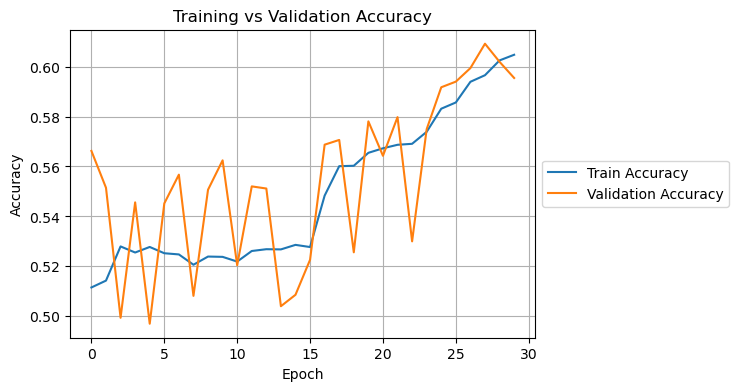

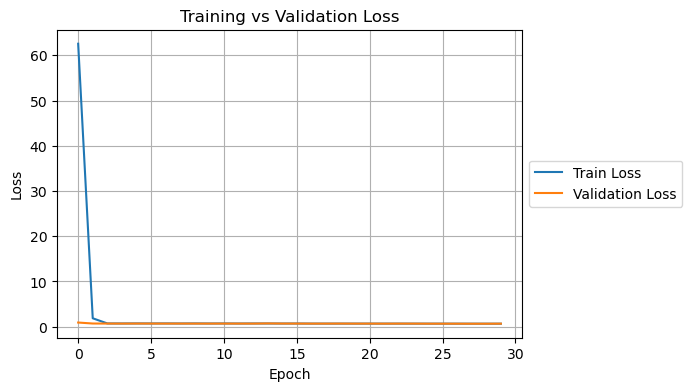

In [36]:
def plot_training_vs_overfitting(history):
    """Plot training and validation accuracy to detect overfitting (when gap between 2 is detected)"""
    
    #ACCA
    plt.figure(figsize=(6,4))
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training vs Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
    plt.grid(True)
    plt.show()

    #Losses
    plt.figure(figsize=(6,4))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training vs Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
    plt.grid(True)
    plt.show()
    
plot_training_vs_overfitting(history)

### Training Metrics:
- **Accuracy:** Starts at 51.10% and improves to 58.19% by epoch 20, showing stagnation in later epochs.
- **Loss:** Initial high loss of 216.1865 decreases to 0.6775 by epoch 20, indicating progress in predictions.

### Validation Metrics:
- **Val Accuracy:** Begins at 57.34%, peaks at 58.01% by epoch 17, with fluctuations suggesting inconsistency and potential instability.
- **Val Loss:** Starts at 1.1788, ends at 0.6785, indicating overall decrease but with fluctuations in accuracy, hinting at possible overfitting or underfitting.

### Evaluation Metrics (Test Accuracy):
- **Test Accuracy:** Achieves 57.31%, showing slight improvement but poor generalization.
- **Test Loss:** Final test loss of 0.6793, lower than training loss but still above desired levels.

### Summary
The model shows gradual improvements in training and validation metrics but requires further tuning for optimization. Consider adjusting learning rate, batch size, architecture, or extending training epochs to enhance performance and generalization.


## These are the features that might be available before the loan was taken out

In [37]:
all_cat_features =  ['term', 'int_rate', 'grade', 'sub_grade', 'emp_length', 'home_ownership', 'verification_status', 
                     'issue_d', 'purpose', 'addr_state', 'earliest_cr_line', 'revol_util', 'initial_list_status', 
                     'last_credit_pull_d', 'application_type', 'income_category', 'fico_risk_group', 'loan_term_risk', 
                     'purpose_group']


all_num_features = ['id', 'loan_amnt', 'annual_inc', 'dti', 'delinq_2yrs', 'fico_range_low', 'fico_range_high', 
                    'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal', 'total_acc', 'last_fico_range_high', 
                    'last_fico_range_low', 'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'open_acc_6m', 
                    'open_act_il', 'open_il_12m', 'open_il_24m', 'mths_since_rcnt_il', 'total_bal_il', 'il_util', 
                    'open_rv_12m', 'open_rv_24m', 'max_bal_bc', 'all_util', 'total_rev_hi_lim', 'inq_fi', 
                    'total_cu_tl', 'inq_last_12m', 'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 
                    'chargeoff_within_12_mths', 'delinq_amnt', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 
                    'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc', 'mths_since_recent_bc', 'mths_since_recent_inq', 
                    'mths_since_recent_revol_delinq', 'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl', 
                    'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl', 'num_rev_accts', 'num_rev_tl_bal_gt_0', 
                    'num_sats', 'num_tl_120dpd_2m', 'num_tl_30dpd', 'num_tl_90g_dpd_24m', 'num_tl_op_past_12m', 
                    'pct_tl_nvr_dlq', 'percent_bc_gt_75', 'pub_rec_bankruptcies', 'tax_liens', 'tot_hi_cred_lim', 
                    'total_bal_ex_mort', 'total_bc_limit', 'total_il_high_credit_limit', 'issue_year', 'issue_month', 
                    'emp_length_int', 'term_numeric', 'revol_util_int', 'int_rate_int', 'high_dti_risk', 
                    'recent_inquiry_flag', 'loan_to_income_ratio', 'interest_to_income_ratio', 'delinquency_risk', 
                    'public_record_flag', 'home_ownership_risk']


df[all_cat_features + all_num_features].head(2)

,term,int_rate,grade,sub_grade,emp_length,home_ownership,verification_status,issue_d,purpose,addr_state,earliest_cr_line,revol_util,initial_list_status,last_credit_pull_d,application_type,income_category,fico_risk_group,loan_term_risk,purpose_group,id,loan_amnt,annual_inc,dti,delinq_2yrs,fico_range_low,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,total_acc,last_fico_range_high,last_fico_range_low,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,issue_year,issue_month,emp_length_int,term_numeric,revol_util_int,int_rate_int,high_dti_risk,recent_inquiry_flag,loan_to_income_ratio,interest_to_income_ratio,delinquency_risk,public_record_flag,home_ownership_risk
2,36 months,10.49%,B,B3,10+ years,MORTGAGE,Not Verified,2015-01-01,credit_card,FL,Apr-2010,52.6%,f,2020-05-01,Individual,Medium,Fair,Short term,Personal,39589826,5000.0,55000.0,7.22,0.0,665.0,669.0,0.0,7.0,1.0,6001.0,9.0,789.0,785.0,0.0,0.0,159131.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11400.0,NaN,NaN,NaN,4.0,22733.0,4521.0,54.8,0.0,0.0,57.0,57.0,14.0,9.0,1.0,14.0,1.0,NaN,0.0,3.0,5.0,3.0,3.0,2.0,5.0,6.0,5.0,7.0,0.0,0.0,0.0,1.0,100.0,33.3,0.0,1.0,171118.0,13124.0,10000.0,7526.0,2015,1,10.0,36,52.6,10.49,0,0,0.090909,0.002954,0,1,1
4,60 months,13.59%,C,C2,10+ years,MORTGAGE,Source Verified,2018-01-01,debt_consolidation,NE,Apr-2008,27.1%,w,2020-02-01,Individual,Low,Good,Long term,Other,127097355,14000.0,48000.0,24.30,0.0,735.0,739.0,1.0,16.0,0.0,11894.0,23.0,779.0,775.0,0.0,0.0,90253.0,2.0,2.0,1.0,1.0,7.0,22953.0,60.0,3.0,4.0,3907.0,43.0,43900.0,1.0,0.0,2.0,5.0,5641.0,17318.0,39.9,0.0,0.0,72.0,117.0,6.0,6.0,2.0,6.0,5.0,NaN,0.0,4.0,5.0,5.0,6.0,5.0,13.0,16.0,5.0,16.0,0.0,0.0,0.0,4.0,100.0,0.0,0.0,0.0,152081.0,34847.0,28800.0,38181.0,2018,1,10.0,60,27.1,13.59,0,0,0.291667,0.006725,0,0,1


In [38]:
df_dummified = pd.get_dummies(df[all_cat_features + all_num_features], columns=all_cat_features, drop_first=True)

imputer = SimpleImputer(strategy='median')  #Andrea likes median
X = imputer.fit_transform(df_dummified)
y = df['loan_status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [39]:
input_dim = X_train.shape[1]

#NN model
nn_model_all = Sequential()
nn_model_all.add(Dense(128, activation='relu', input_shape=(input_dim,))) 
nn_model_all.add(Dense(64, activation='relu'))  
nn_model_all.add(Dense(1, activation='sigmoid'))  

nn_model_all.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history_all = nn_model_all.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

loss_all, accuracy_all = nn_model_all.evaluate(X_test, y_test)
print(f'Accuracy: {accuracy:.4f}')

Epoch 1/10
1274/1274 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.6895 - loss: 51470.3008 - val_accuracy: 0.7794 - val_loss: 889.8572
Epoch 2/10
1274/1274 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6960 - loss: 14638.4697 - val_accuracy: 0.7799 - val_loss: 1701.6996
Epoch 3/10
1274/1274 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6933 - loss: 3788.1958 - val_accuracy: 0.2810 - val_loss: 6974.9863
Epoch 4/10
1274/1274 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6911 - loss: 2256.7285 - val_accuracy: 0.7964 - val_loss: 1180.3862
Epoch 5/10
1274/1274 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6960 - loss: 1041.3276 - val_accuracy: 0.8045 - val_loss: 1976.6211
Epoch 6/10
1274/1274 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6954 - loss: 525.9001 - val_accuracy: 0.7934 - val_loss: 271.6156
Epoch 7/10
1274/1274 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6835 - loss: 173.1651 - val_accuracy: 0.8042 - val_loss: 44.4684
Epoch 8/10
1274/1274 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/ste

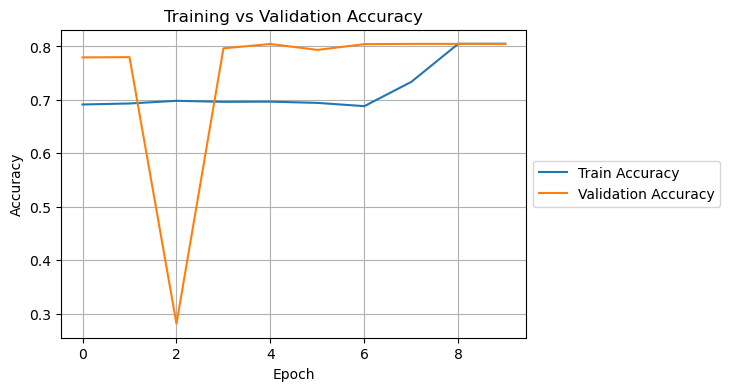

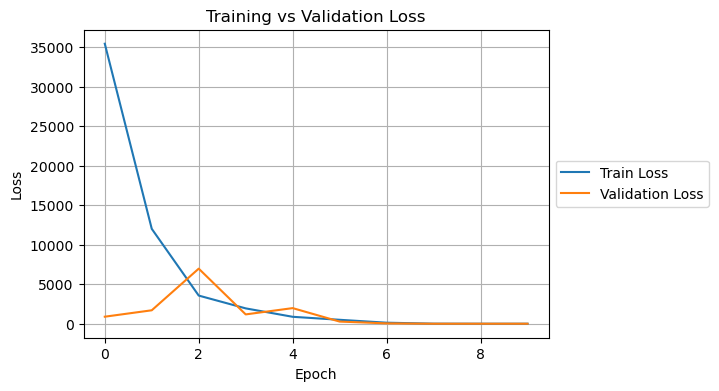

In [40]:
plot_training_vs_overfitting(history_all)

### Training Metrics:
- **Accuracy:** Starts at 68.92% in epoch 1, fluctuates slightly, and ends at 80.54% by epoch 10, indicating a general upward trend in model performance.
- **Loss:** Begins very high at 46388.1719, decreases significantly to 0.4992 by epoch 10, demonstrating effective model optimization over time.

### Validation Metrics:
- **Val Accuracy:** Starts at 33.48% in epoch 1, peaks at 80.48% by epoch 9, and ends at 79.62% by epoch 10. This shows significant improvement and stability during training.
- **Val Loss:** Begins at 6691.4736, decreases to 0.6759 by epoch 10, indicating improved model performance, though fluctuations in validation accuracy suggest some inconsistency.

### Evaluation Metrics (Test Accuracy):
- **Test Accuracy:** After training, the model achieves a test accuracy of 78.93%, reflecting good generalization as it performs well on unseen data.
- **Test Loss:** The final test loss is 0.5076, which shows a substantial reduction from initial values, indicating well-tuned performance.

### Summary:
The model exhibits consistent improvements in both training and validation metrics, achieving a final test accuracy of 78.93%. While some fluctuations in validation accuracy exist, the overall trends are positive, suggesting the model is effectively learning. Further tuning, such as adjusting learning rates or model architecture, could lead to additional performance gains.


## Results

The modeling phase of the project involved an extensive exploration of various algorithms to determine the most effective approach for predicting loan defaults. Each model was carefully evaluated based on its predictive performance, interpretability, and ability to handle the complexities of the dataset.

- The standout performer was the **XGBoost model**, which achieved an impressive accuracy of approximately **80%**. This gradient boosting algorithm excelled in capturing non-linear relationships and complex interactions among the features, making it particularly adept at identifying the key factors contributing to loan defaults. Given its superior performance, the XGBoost model was selected as the **baseline model** for future comparisons.

- **Logistic Regression** was also explored, providing a baseline for interpretability. Despite its lower predictive performance, this model allowed for clear insights into the relationships between features and the target variable. It was particularly useful for understanding how variables such as `annual_inc` and `dti` influenced the likelihood of default, though it struggled with capturing complex patterns in the data.

- Additionally, **Linear Regression** was employed to assess potential linear relationships within the dataset. While it provided some insights, it was less effective than XGBoost and Logistic Regression in predicting loan defaults due to its limitations in accounting for non-linearities.

- The **neural network model**, referred to as the **Challenger Model**, was developed to further enhance predictive accuracy. This model underwent several iterations, focusing on optimizing hyperparameters, adjusting the architecture, and adding hidden layers to improve performance. Although the neural network showed promise, it was still under development and required further refinement. Initial tests indicated that it was capable of capturing intricate patterns in the data, but the results were not yet as robust as those achieved with XGBoost.

Throughout the modeling process, various metrics were utilized to evaluate performance, including accuracy, precision, recall, and F1 score. Each model was subjected to rigorous cross-validation to ensure reliability and to mitigate overfitting. The exploration of different algorithms underscored the importance of selecting the right model for the task, as the performance varied significantly across approaches.

In summary, while simpler models like Logistic and Linear Regression provided valuable insights and interpretability, the XGBoost model stood out for its predictive power. The ongoing development of the neural network model holds potential for further improvements, and its continued refinement could lead to even better performance in predicting loan defaults. These findings will inform future analyses and model enhancements, particularly in the context of financial risk assessment.


## Future Work

As the project progresses, several key areas have been identified for further exploration and improvement:

1. **Model Refinement**: The neural network model will undergo additional tuning of hyperparameters, architecture adjustments, and experimentation with different optimizers. This iterative process aims to optimize its performance and minimize overfitting, potentially leading to superior predictive accuracy.

2. **Feature Engineering**: There remains an opportunity to explore additional features and transformations that could enhance model performance. Incorporating more granular variables or external data sources may provide deeper insights into the factors influencing loan defaults.

3. **Interpretability Enhancements**: To better understand model predictions, implementing techniques such as SHAP (SHapley Additive exPlanations) or LIME (Local Interpretable Model-agnostic Explanations) will be prioritized. These tools will aid in interpreting feature importance and improving the transparency of the models.

4. **Ensemble Methods**: Exploring ensemble methods that combine the strengths of multiple algorithms could yield improved results. Techniques such as stacking or blending could be applied to leverage the predictive power of different models effectively.

5. **Deployment**: Plans are in place to deploy the final model as an API using FastAPI. This will enable real-time predictions for new loan applications and facilitate easier integration into existing systems.

6. **Monitoring and Maintenance**: Post-deployment, it will be essential to monitor model performance over time to ensure its continued accuracy. Establishing a feedback loop for continuous improvement based on new data will help maintain the model’s relevance in a changing financial landscape.

By focusing on these areas, the project aims to enhance predictive capabilities, improve model interpretability, and ensure that the deployed solution effectively meets user needs in real-world applications.
